## Inprocessing - Adversial Debiasing  -  Compas Model
- for 'sex' and 'race'

In [1]:
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), "../.."))
sys.path.insert(0, project_root)

import tensorflow.compat.v1 as tf
from tensorflow.compat.v1 import reset_default_graph
import pandas as pd
from src.data_loading import load_compas_sex, load_compas_race
from src.modeling import adversial_debiasing_train_and_predict
from src.metrics import compute_metrics, compare_viz_metrics_2x3
from aif360.algorithms.inprocessing import AdversarialDebiasing
from aif360.datasets import BinaryLabelDataset
from sklearn.model_selection import StratifiedShuffleSplit
import pandas as pd

/opt/anaconda3/lib/python3.11/site-packages/inFairness/utils/ndcg.py:37: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.vmap` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.vmap` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  vect_normalized_discounted_cumulative_gain = vmap(
/opt/anaconda3/lib/python3.11/site-packages/inFairness/utils/ndcg.py:48: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.vmap` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.vmap` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  monte_carlo_vect_ndcg = vmap(vect_normalized_di

In [2]:
baseline_race_agg = pd.read_csv('../../reports/baseline_agg/compas_race_metrics_agg.csv', index_col=0)
baseline_sex_agg = pd.read_csv('../../reports/baseline_agg/compas_sex_metrics_agg.csv', index_col=0)

--------------------------------------------------------------------------------------------------------------------------------------

## Build up the function using race

In [3]:
# 1) Retrieve data
protected           = 'race'
privileged_value    = 0.0
unprivileged_value  = 1.0
privileged_groups   = [{protected: privileged_value}]
unprivileged_groups = [{protected: unprivileged_value}]
tf.disable_v2_behavior()

ds, df = load_compas_race()  
feature_cols = [c for c in df.columns if c not in ('label','race')]

# 2) Run experiment, Evaluate
sss = StratifiedShuffleSplit(n_splits=25, test_size=0.2, random_state=42)

results = []
for i, (train_idx, test_idx) in enumerate(sss.split(df, df['label'])):
    # Reset TF graph - start new session (to avoid "Variable … already exists")
    reset_default_graph()
    sess = tf.Session()

    train_df = df.iloc[train_idx].reset_index(drop=True)
    test_df  = df.iloc[test_idx].reset_index(drop=True)

    # Wrap into AIF360 
    train_bld = BinaryLabelDataset(
        df=train_df,
        label_names=['label'],
        protected_attribute_names=[protected],
        favorable_label=1.0,
        unfavorable_label=0.0,
        privileged_protected_attributes=[[privileged_value]],
        unprivileged_protected_attributes=[[unprivileged_value]]
    )
    test_bld = BinaryLabelDataset(
        df=test_df,
        label_names=['label'],
        protected_attribute_names=[protected],
        favorable_label=1.0,
        unfavorable_label=0.0,
        privileged_protected_attributes=[[privileged_value]],
        unprivileged_protected_attributes=[[unprivileged_value]]
    )

    # Instantiate & train AdversarialDebiasing
    adv = AdversarialDebiasing(
        privileged_groups=privileged_groups,
        unprivileged_groups=unprivileged_groups,
        scope_name='adv',             
        debias=True,
        sess=sess
    )
    adv.fit(train_bld)

    # Predict on test split
    pred_bld = adv.predict(test_bld)
    y_test   = test_df['label'].values
    y_pred   = pred_bld.labels.ravel()

    # Compute & store metrics
    m = compute_metrics(
        test_df, y_test, y_pred,
        protected, privileged_value, unprivileged_value
    )
    results.append(m)

    sess.close()

compas_race_metrics = pd.DataFrame(results)
compas_race_metrics_agg = compas_race_metrics.agg(['mean','std'])

print(compas_race_metrics_agg)

Instructions for updating:
non-resource variables are not supported in the long term
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


2025-05-20 21:28:10.824318: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled


epoch 0; iter: 0; batch classifier loss: 4.511823; batch adversarial loss: 1.281864
epoch 1; iter: 0; batch classifier loss: 0.938679; batch adversarial loss: 1.127085
epoch 2; iter: 0; batch classifier loss: 1.056706; batch adversarial loss: 1.125362
epoch 3; iter: 0; batch classifier loss: 0.872766; batch adversarial loss: 1.021018
epoch 4; iter: 0; batch classifier loss: 0.914595; batch adversarial loss: 1.036035
epoch 5; iter: 0; batch classifier loss: 0.822123; batch adversarial loss: 1.026370
epoch 6; iter: 0; batch classifier loss: 0.896302; batch adversarial loss: 1.001893
epoch 7; iter: 0; batch classifier loss: 0.882381; batch adversarial loss: 0.934374
epoch 8; iter: 0; batch classifier loss: 0.834427; batch adversarial loss: 0.922413
epoch 9; iter: 0; batch classifier loss: 0.862756; batch adversarial loss: 0.878595
epoch 10; iter: 0; batch classifier loss: 0.889482; batch adversarial loss: 0.868603
epoch 11; iter: 0; batch classifier loss: 0.995138; batch adversarial loss:

## refactor function

In [4]:
# 1) Retrieve data
protected           = 'race'
privileged_value    = 0.0
unprivileged_value  = 1.0
privileged_groups   = [{protected: privileged_value}]
unprivileged_groups = [{protected: unprivileged_value}]

tf.disable_v2_behavior()
ds, df = load_compas_race()  
feature_cols = [c for c in df.columns if c not in ('label','race')]

# 2) Run experiment, Evaluate
sss = StratifiedShuffleSplit(n_splits=25, test_size=0.2, random_state=42)

results = []
for i, (train_idx, test_idx) in enumerate(sss.split(df, df['label'])):
    test_df, y_test, y_pred = adversial_debiasing_train_and_predict(
    df,
    train_idx,
    test_idx,
    protected,
    privileged_value,
    unprivileged_value,
    privileged_groups,
    unprivileged_groups,
    scope_name='adv',           
    num_epochs=50,
    batch_size=128,
    adversary_loss_weight=0.1)
    
    m = compute_metrics(
        test_df, y_test, y_pred,
        protected, privileged_value, unprivileged_value
    )
    results.append(m)

compas_race_metrics = pd.DataFrame(results)
compas_race_metrics_agg = compas_race_metrics.agg(['mean','std'])

print(compas_race_metrics_agg)

epoch 0; iter: 0; batch classifier loss: 0.672815; batch adversarial loss: 0.745220
epoch 1; iter: 0; batch classifier loss: 0.632474; batch adversarial loss: 0.719776
epoch 2; iter: 0; batch classifier loss: 0.576933; batch adversarial loss: 0.710348
epoch 3; iter: 0; batch classifier loss: 0.584802; batch adversarial loss: 0.691518
epoch 4; iter: 0; batch classifier loss: 0.605061; batch adversarial loss: 0.680074
epoch 5; iter: 0; batch classifier loss: 0.645983; batch adversarial loss: 0.688904
epoch 6; iter: 0; batch classifier loss: 0.577822; batch adversarial loss: 0.647606
epoch 7; iter: 0; batch classifier loss: 0.533385; batch adversarial loss: 0.652232
epoch 8; iter: 0; batch classifier loss: 0.572841; batch adversarial loss: 0.652049
epoch 9; iter: 0; batch classifier loss: 0.519513; batch adversarial loss: 0.621741
epoch 10; iter: 0; batch classifier loss: 0.617656; batch adversarial loss: 0.695366
epoch 11; iter: 0; batch classifier loss: 0.609944; batch adversarial loss:

KeyboardInterrupt: 

In [ ]:
baseline_race_agg = pd.read_csv('../../reports/baseline_agg/compas_race_metrics_agg.csv', index_col=0)
baseline_sex_agg = pd.read_csv('../../reports/baseline_agg/compas_sex_metrics_agg.csv', index_col=0)

In [ ]:
baseline_race_agg

In [ ]:
compare_viz_metrics_2x3(baseline_race_agg, compas_race_metrics_agg, 'Baseline', 'Race', 'Adversial Debiasing Adult: Baseline - Race')

## Hyperparametersearch

In [ ]:
from sklearn.model_selection import ParameterGrid
import pandas as pd

# 1) Define the hyperparameter grid
param_grid = {
    'adversary_loss_weight': [0.5, 1.0],
    'num_epochs':            [10,20, 50],
    'batch_size':            [64, 128]
}
grid = list(ParameterGrid(param_grid))

# 2) Prepare to collect results
grid_results = []

# each hyperparam setting
for params in grid:
    print(f"Testing config: {params}")
    fold_metrics = []
    
    sss = StratifiedShuffleSplit(n_splits=25, test_size=0.2, random_state=42)

    for train_idx, test_idx in sss.split(df, df['label']):
        test_df, y_test, y_pred = adversial_debiasing_train_and_predict(
            df, train_idx, test_idx,
            protected, privileged_value, unprivileged_value,
            privileged_groups, unprivileged_groups,
            scope_name='adv',
            num_epochs=params['num_epochs'],
            batch_size=params['batch_size'],
            adversary_loss_weight=params['adversary_loss_weight']
        )
        m = compute_metrics(
            test_df, y_test, y_pred,
            protected, privileged_value, unprivileged_value
        )
        fold_metrics.append(m)
    
    df_fm = pd.DataFrame(fold_metrics)
    agg = df_fm.agg(['mean','std'])
    
    grid_results.append({
        **params,
        'acc_mean':   agg.loc['mean','accuracy'],
        'acc_std':    agg.loc['std', 'accuracy'],
        'f1_mean':    agg.loc['mean','f1_score'],
        'f1_std':     agg.loc['std', 'f1_score'],
        'SPD_mean':   agg.loc['mean','SPD'],
        'SPD_std':    agg.loc['std', 'SPD'],
        'DI_mean':    agg.loc['mean','DI'],
        'DI_std':     agg.loc['std', 'DI'],
        'EOD_mean':   agg.loc['mean','EOD'],
        'EOD_std':    agg.loc['std', 'EOD'],
        'AOD_mean':   agg.loc['mean','AOD'],
        'AOD_std':    agg.loc['std', 'AOD'],
    })

results_df = pd.DataFrame(grid_results)

In [ ]:
results_df

In [ ]:
# thresholds fairness
di_min, di_max        = 0.8, 1.25
spd_thresh, eod_thresh, aod_thresh = 0.1, 0.1, 0.1

# filter for configs that satisfy ALL four fairness bounds
fair_configs = results_df[
    (results_df['DI_mean']  >= di_min)  & (results_df['DI_mean']  <= di_max)   &
    (results_df['SPD_mean'].abs() <= spd_thresh)                              &
    (results_df['EOD_mean'].abs() <= eod_thresh)                              &
    (results_df['AOD_mean'].abs() <= aod_thresh)
]

# 3) Sort by (1) acc_mean ↓, (2) acc_std ↑
best = fair_configs.sort_values(
    by=['acc_mean','acc_std','DI_std'],
    ascending=[False,    True,     True]
).iloc[0]
best

- refactor best_hyperparam searcher

In [ ]:
from src.metrics import best_hyperparameter_advdeb
from sklearn.model_selection import StratifiedKFold

best_param = best_hyperparameter_advdeb(results_df)
loss_weight = best_param['adversary_loss_weight']
n_epochs    = int(best_param['num_epochs'])
batch_sz    = int(best_param['batch_size'])

folds = StratifiedKFold(n_splits=25, shuffle=True, random_state=42)
metrics = []
for train_idx, test_idx in folds.split(df, df['label']):
    test_df, y_test, y_pred = adversial_debiasing_train_and_predict(
        df, train_idx, test_idx,
        protected, privileged_value, unprivileged_value,
        privileged_groups, unprivileged_groups,
        scope_name='adv',
        num_epochs=n_epochs,
        batch_size=batch_sz,
        adversary_loss_weight=loss_weight
    )
    m = compute_metrics(test_df, y_test, y_pred,
                        protected, privileged_value, unprivileged_value)
    metrics.append(m)
final_df = pd.DataFrame(metrics)
print(final_df.agg(['mean','std']))

In [ ]:
compare_viz_metrics_2x3(baseline_race_agg, final_df.agg(['mean','std']), 'Baseline', 'Race', 'Adversial Debiasing Adult: Baseline - Race')

--------------------------------------------------------------------------------------------------------------------------------------

## default adversial debiaser, race

In [5]:
# 1) Retrieve data
protected           = 'race'
privileged_value    = 0.0
unprivileged_value  = 1.0
privileged_groups   = [{protected: privileged_value}]
unprivileged_groups = [{protected: unprivileged_value}]

tf.disable_v2_behavior()
ds, df = load_compas_race()  
feature_cols = [c for c in df.columns if c not in ('label','race')]

# 2) Run experiment, Evaluate
sss = StratifiedShuffleSplit(n_splits=25, test_size=0.2, random_state=42)

results = []
for i, (train_idx, test_idx) in enumerate(sss.split(df, df['label'])):
    test_df, y_test, y_pred = adversial_debiasing_train_and_predict(
    df,
    train_idx,
    test_idx,
    protected,
    privileged_value,
    unprivileged_value,
    privileged_groups,
    unprivileged_groups,
    scope_name='adv',           
    num_epochs=50,
    batch_size=128,
    adversary_loss_weight=0.1)
    
    m = compute_metrics(
        test_df, y_test, y_pred,
        protected, privileged_value, unprivileged_value
    )
    results.append(m)

# 3) Aggregate
compas_race_metrics = pd.DataFrame(results)
compas_race_metrics_agg = compas_race_metrics.agg(['mean','std'])
print(compas_race_metrics_agg)

epoch 0; iter: 0; batch classifier loss: 0.683779; batch adversarial loss: 0.729991
epoch 1; iter: 0; batch classifier loss: 0.636665; batch adversarial loss: 0.711108
epoch 2; iter: 0; batch classifier loss: 0.553750; batch adversarial loss: 0.691641
epoch 3; iter: 0; batch classifier loss: 0.620989; batch adversarial loss: 0.684498
epoch 4; iter: 0; batch classifier loss: 0.629502; batch adversarial loss: 0.668869
epoch 5; iter: 0; batch classifier loss: 0.632568; batch adversarial loss: 0.658058
epoch 6; iter: 0; batch classifier loss: 0.610522; batch adversarial loss: 0.642849
epoch 7; iter: 0; batch classifier loss: 0.659660; batch adversarial loss: 0.614622
epoch 8; iter: 0; batch classifier loss: 0.617075; batch adversarial loss: 0.660134
epoch 9; iter: 0; batch classifier loss: 0.624891; batch adversarial loss: 0.644334
epoch 10; iter: 0; batch classifier loss: 0.627408; batch adversarial loss: 0.645241
epoch 11; iter: 0; batch classifier loss: 0.578677; batch adversarial loss:

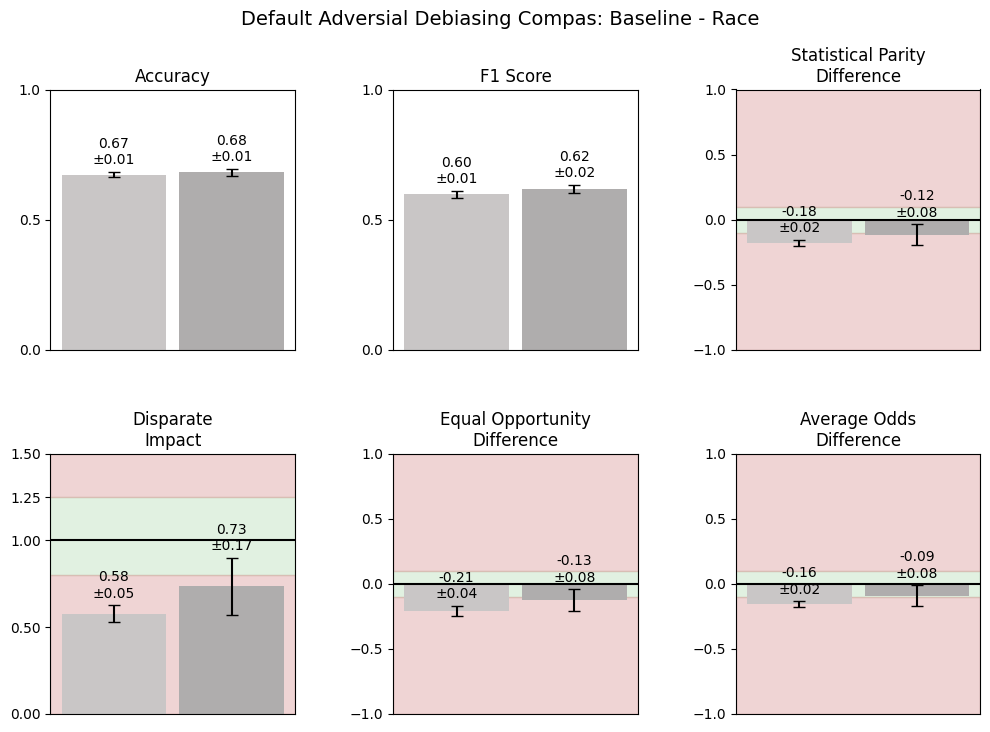

In [6]:
compare_viz_metrics_2x3(baseline_race_agg, compas_race_metrics_agg, 'Baseline', 'Race', 'Default Adversial Debiasing Compas: Baseline - Race')

## default adversial debiaser, sex

In [7]:
# 1) Retrieve data
protected           = 'sex'
privileged_value    = 0.0
unprivileged_value  = 1.0
privileged_groups   = [{protected: privileged_value}]
unprivileged_groups = [{protected: unprivileged_value}]

tf.disable_v2_behavior()
ds, df = load_compas_sex()  
feature_cols = [c for c in df.columns if c not in ('label','sex')]

# 2) Run experiment, Evaluate
sss = StratifiedShuffleSplit(n_splits=25, test_size=0.2, random_state=42)

results = []
for i, (train_idx, test_idx) in enumerate(sss.split(df, df['label'])):
    test_df, y_test, y_pred = adversial_debiasing_train_and_predict(
    df,
    train_idx,
    test_idx,
    protected,
    privileged_value,
    unprivileged_value,
    privileged_groups,
    unprivileged_groups,
    scope_name='adv',           
    num_epochs=50,
    batch_size=128,
    adversary_loss_weight=0.1)
    
    m = compute_metrics(
        test_df, y_test, y_pred,
        protected, privileged_value, unprivileged_value
    )
    results.append(m)

# 3) Aggregate
compas_sex_metrics = pd.DataFrame(results)
compas_sex_metrics_agg = compas_sex_metrics.agg(['mean','std'])
print(compas_race_metrics_agg)

epoch 0; iter: 0; batch classifier loss: 0.682320; batch adversarial loss: 0.932833
epoch 1; iter: 0; batch classifier loss: 0.636386; batch adversarial loss: 0.968928
epoch 2; iter: 0; batch classifier loss: 0.773625; batch adversarial loss: 1.064967
epoch 3; iter: 0; batch classifier loss: 0.884941; batch adversarial loss: 1.057170
epoch 4; iter: 0; batch classifier loss: 0.986912; batch adversarial loss: 1.004974
epoch 5; iter: 0; batch classifier loss: 0.904815; batch adversarial loss: 0.903259
epoch 6; iter: 0; batch classifier loss: 1.047821; batch adversarial loss: 0.890173
epoch 7; iter: 0; batch classifier loss: 0.970204; batch adversarial loss: 0.814412
epoch 8; iter: 0; batch classifier loss: 1.086000; batch adversarial loss: 0.788283
epoch 9; iter: 0; batch classifier loss: 0.927098; batch adversarial loss: 0.739599
epoch 10; iter: 0; batch classifier loss: 1.054379; batch adversarial loss: 0.701833
epoch 11; iter: 0; batch classifier loss: 0.894133; batch adversarial loss:

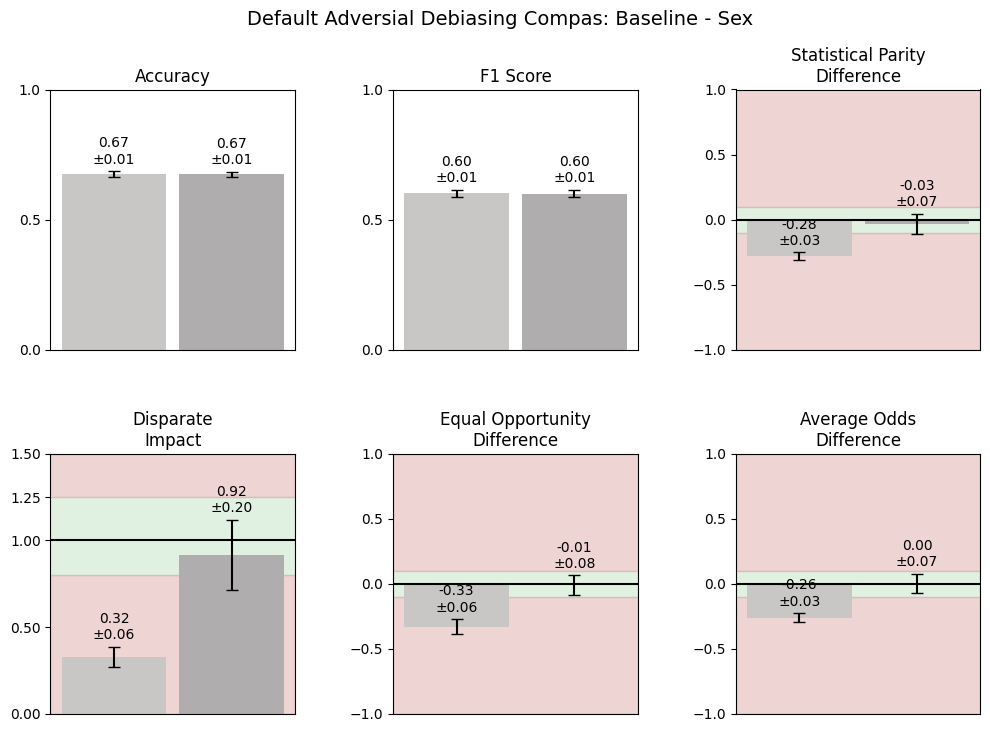

In [8]:
compare_viz_metrics_2x3(baseline_sex_agg, compas_sex_metrics_agg, 'Baseline', 'Race', 'Default Adversial Debiasing Compas: Baseline - Sex')

## hyperparameter search adversial debiaser, race

In [9]:
import pandas as pd
from sklearn.model_selection import ParameterGrid, StratifiedShuffleSplit, StratifiedKFold
from src.metrics import best_hyperparameter_advdeb

# 1) Retrieve data
protected           = 'race'
privileged_value    = 0.0
unprivileged_value  = 1.0
privileged_groups   = [{protected: privileged_value}]
unprivileged_groups = [{protected: unprivileged_value}]

tf.disable_v2_behavior()
ds, df = load_compas_race()  
feature_cols = [c for c in df.columns if c not in ('label','race')]

# 2) Hyperparameter Search
param_grid = {
    'adversary_loss_weight': [0.5, 1.0],
    'num_epochs':            [10, 20, 50],
    'batch_size':            [64, 128]
}
grid = list(ParameterGrid(param_grid))

grid_results = []
# Perform hyperparameter search with 15 stratified shuffle splits
for params in grid:
    print(f"Testing config: {params}")
    fold_metrics = []
    sss = StratifiedShuffleSplit(n_splits=15, test_size=0.2, random_state=42)

    for train_idx, test_idx in sss.split(df, df['label']):
        test_df, y_test, y_pred = adversial_debiasing_train_and_predict(
            df, train_idx, test_idx,
            protected, privileged_value, unprivileged_value,
            privileged_groups, unprivileged_groups,
            scope_name='adv',
            num_epochs=params['num_epochs'],
            batch_size=params['batch_size'],
            adversary_loss_weight=params['adversary_loss_weight']
        )
        m = compute_metrics(
            test_df, y_test, y_pred,
            protected, privileged_value, unprivileged_value
        )
        fold_metrics.append(m)
    
    df_fm = pd.DataFrame(fold_metrics)
    agg = df_fm.agg(['mean', 'std'])
    
    grid_results.append({
        **params,
        'acc_mean':   agg.loc['mean', 'accuracy'],
        'acc_std':    agg.loc['std',  'accuracy'],
        'f1_mean':    agg.loc['mean', 'f1_score'],
        'f1_std':     agg.loc['std',  'f1_score'],
        'SPD_mean':   agg.loc['mean', 'SPD'],
        'SPD_std':    agg.loc['std',  'SPD'],
        'DI_mean':    agg.loc['mean', 'DI'],
        'DI_std':     agg.loc['std',  'DI'],
        'EOD_mean':   agg.loc['mean', 'EOD'],
        'EOD_std':    agg.loc['std',  'EOD'],
        'AOD_mean':   agg.loc['mean', 'AOD'],
        'AOD_std':    agg.loc['std',  'AOD'],
    })

results_df = pd.DataFrame(grid_results)

# 3) Hyperparameter Selection
best_param = best_hyperparameter_advdeb(results_df)
print(f"Best parameters: {best_param}")

# Final evaluation with StratifiedKFold
loss_weight = best_param['adversary_loss_weight']
n_epochs    = int(best_param['num_epochs'])
batch_sz    = int(best_param['batch_size'])

# 4) Run experiment, Evaluate
results = []
folds = StratifiedKFold(n_splits=25, shuffle=True, random_state=42)

for train_idx, test_idx in folds.split(df, df['label']):
    test_df, y_test, y_pred = adversial_debiasing_train_and_predict(
        df, train_idx, test_idx,
        protected, privileged_value, unprivileged_value,
        privileged_groups, unprivileged_groups,
        scope_name='adv',
        num_epochs=n_epochs,
        batch_size=batch_sz,
        adversary_loss_weight=loss_weight
    )
    m = compute_metrics(
        test_df, y_test, y_pred,
        protected, privileged_value, unprivileged_value
    )
    results.append(m)
    
# 5) Aggregate results
compas_race_metrics = pd.DataFrame(results)
compas_race_metrics_agg = compas_race_metrics.agg(['mean','std'])
print(compas_race_metrics_agg)

Testing config: {'adversary_loss_weight': 0.5, 'batch_size': 64, 'num_epochs': 10}
epoch 0; iter: 0; batch classifier loss: 0.715111; batch adversarial loss: 0.696118
epoch 1; iter: 0; batch classifier loss: 0.576255; batch adversarial loss: 0.662414
epoch 2; iter: 0; batch classifier loss: 0.747404; batch adversarial loss: 0.702850
epoch 3; iter: 0; batch classifier loss: 0.732134; batch adversarial loss: 0.702049
epoch 4; iter: 0; batch classifier loss: 0.658231; batch adversarial loss: 0.661831
epoch 5; iter: 0; batch classifier loss: 0.670587; batch adversarial loss: 0.626944
epoch 6; iter: 0; batch classifier loss: 0.575824; batch adversarial loss: 0.609151
epoch 7; iter: 0; batch classifier loss: 0.652384; batch adversarial loss: 0.626460
epoch 8; iter: 0; batch classifier loss: 0.665767; batch adversarial loss: 0.705790
epoch 9; iter: 0; batch classifier loss: 0.614851; batch adversarial loss: 0.588402
epoch 0; iter: 0; batch classifier loss: 0.686257; batch adversarial loss: 0.

/opt/anaconda3/lib/python3.11/site-packages/aif360/metrics/dataset_metric.py:82: RuntimeWarning: divide by zero encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)


epoch 0; iter: 0; batch classifier loss: 0.688818; batch adversarial loss: 0.717875
epoch 1; iter: 0; batch classifier loss: 0.594874; batch adversarial loss: 0.770663
epoch 2; iter: 0; batch classifier loss: 0.592985; batch adversarial loss: 0.765256
epoch 3; iter: 0; batch classifier loss: 0.758814; batch adversarial loss: 0.767880
epoch 4; iter: 0; batch classifier loss: 0.715033; batch adversarial loss: 0.725819
epoch 5; iter: 0; batch classifier loss: 0.755705; batch adversarial loss: 0.708617
epoch 6; iter: 0; batch classifier loss: 0.655076; batch adversarial loss: 0.664929
epoch 7; iter: 0; batch classifier loss: 0.549252; batch adversarial loss: 0.643694
epoch 8; iter: 0; batch classifier loss: 0.616348; batch adversarial loss: 0.631410
epoch 9; iter: 0; batch classifier loss: 0.604990; batch adversarial loss: 0.629995
epoch 0; iter: 0; batch classifier loss: 0.719620; batch adversarial loss: 0.702608
epoch 1; iter: 0; batch classifier loss: 0.609593; batch adversarial loss: 0

/opt/anaconda3/lib/python3.11/site-packages/aif360/metrics/dataset_metric.py:82: RuntimeWarning: divide by zero encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)


epoch 0; iter: 0; batch classifier loss: 0.713825; batch adversarial loss: 0.682760
epoch 1; iter: 0; batch classifier loss: 0.643873; batch adversarial loss: 0.677635
epoch 2; iter: 0; batch classifier loss: 0.675484; batch adversarial loss: 0.675115
epoch 3; iter: 0; batch classifier loss: 0.676201; batch adversarial loss: 0.679768
epoch 4; iter: 0; batch classifier loss: 0.657385; batch adversarial loss: 0.688841
epoch 5; iter: 0; batch classifier loss: 0.711832; batch adversarial loss: 0.664870
epoch 6; iter: 0; batch classifier loss: 0.627434; batch adversarial loss: 0.660238
epoch 7; iter: 0; batch classifier loss: 0.676553; batch adversarial loss: 0.647849
epoch 8; iter: 0; batch classifier loss: 0.659162; batch adversarial loss: 0.631011
epoch 9; iter: 0; batch classifier loss: 0.617352; batch adversarial loss: 0.639947
epoch 0; iter: 0; batch classifier loss: 0.687023; batch adversarial loss: 0.728539
epoch 1; iter: 0; batch classifier loss: 0.674790; batch adversarial loss: 0

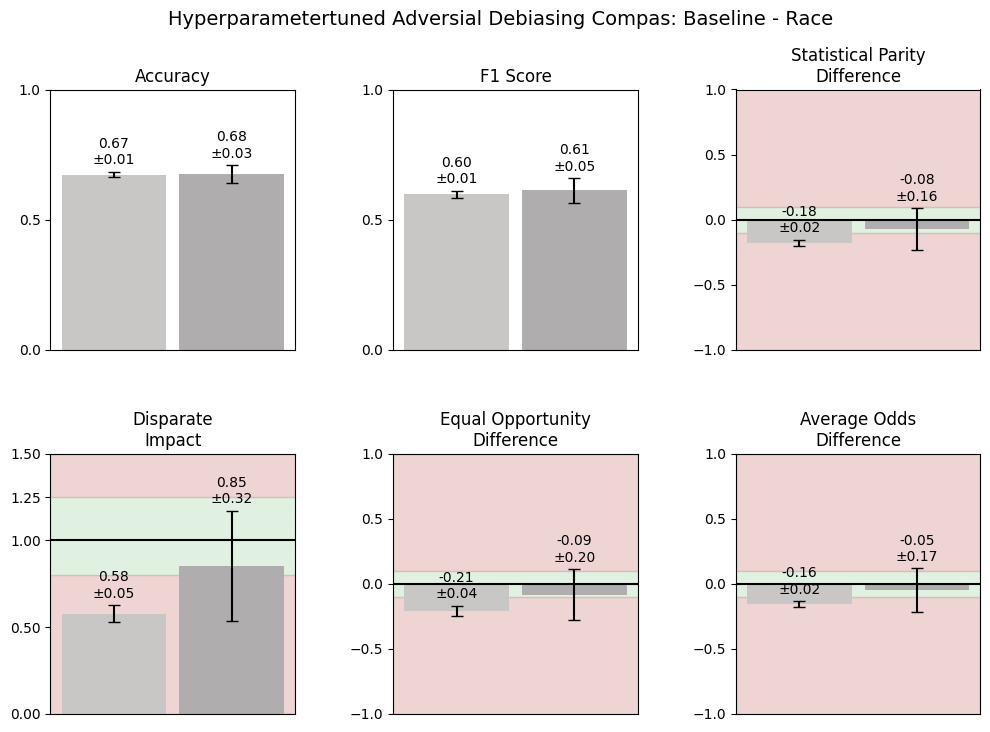

In [10]:
compare_viz_metrics_2x3(baseline_race_agg, compas_race_metrics_agg, 'Baseline', 'Race', 'Hyperparametertuned Adversial Debiasing Compas: Baseline - Race')

## hyperparameter search adversial debiaser, sex

In [11]:
import pandas as pd
from sklearn.model_selection import ParameterGrid, StratifiedShuffleSplit, StratifiedKFold
from src.metrics import best_hyperparameter_advdeb

# 1) Retrieve data
protected           = 'sex'
privileged_value    = 0.0
unprivileged_value  = 1.0
privileged_groups   = [{protected: privileged_value}]
unprivileged_groups = [{protected: unprivileged_value}]

tf.disable_v2_behavior()
ds, df = load_compas_sex()  
feature_cols = [c for c in df.columns if c not in ('label','sex')]

# 2) Hyperparameter Search
param_grid = {
    'adversary_loss_weight': [0.5, 1.0],
    'num_epochs':            [10, 20, 50],
    'batch_size':            [64, 128]
}
grid = list(ParameterGrid(param_grid))

grid_results = []
# Perform hyperparameter search with 15 stratified shuffle splits
for params in grid:
    print(f"Testing config: {params}")
    fold_metrics = []
    sss = StratifiedShuffleSplit(n_splits=15, test_size=0.3, random_state=42)

    for train_idx, test_idx in sss.split(df, df['label']):
        test_df, y_test, y_pred = adversial_debiasing_train_and_predict(
            df, train_idx, test_idx,
            protected, privileged_value, unprivileged_value,
            privileged_groups, unprivileged_groups,
            scope_name='adv',
            num_epochs=params['num_epochs'],
            batch_size=params['batch_size'],
            adversary_loss_weight=params['adversary_loss_weight']
        )
        m = compute_metrics(
            test_df, y_test, y_pred,
            protected, privileged_value, unprivileged_value
        )
        fold_metrics.append(m)
    
    df_fm = pd.DataFrame(fold_metrics)
    agg = df_fm.agg(['mean', 'std'])

    grid_results.append({
        **params,
        'acc_mean':   agg.loc['mean', 'accuracy'],
        'acc_std':    agg.loc['std',  'accuracy'],
        'f1_mean':    agg.loc['mean', 'f1_score'],
        'f1_std':     agg.loc['std',  'f1_score'],
        'SPD_mean':   agg.loc['mean', 'SPD'],
        'SPD_std':    agg.loc['std',  'SPD'],
        'DI_mean':    agg.loc['mean', 'DI'],
        'DI_std':     agg.loc['std',  'DI'],
        'EOD_mean':   agg.loc['mean', 'EOD'],
        'EOD_std':    agg.loc['std',  'EOD'],
        'AOD_mean':   agg.loc['mean', 'AOD'],
        'AOD_std':    agg.loc['std',  'AOD'],
    })

results_df = pd.DataFrame(grid_results)

# 3) Hyperparameter Selection
best_param = best_hyperparameter_advdeb(results_df)
print(f"Best parameters: {best_param}")

# Final evaluation with StratifiedKFold
loss_weight = best_param['adversary_loss_weight']
n_epochs    = int(best_param['num_epochs'])
batch_sz    = int(best_param['batch_size'])

# 4) Run experiment, Evaluate
final_metrics = []
folds = StratifiedKFold(n_splits=25, shuffle=True, random_state=42)

for train_idx, test_idx in folds.split(df, df['label']):
    test_df, y_test, y_pred = adversial_debiasing_train_and_predict(
        df, train_idx, test_idx,
        protected, privileged_value, unprivileged_value,
        privileged_groups, unprivileged_groups,
        scope_name='adv',
        num_epochs=n_epochs,
        batch_size=batch_sz,
        adversary_loss_weight=loss_weight
    )
    m = compute_metrics(
        test_df, y_test, y_pred,
        protected, privileged_value, unprivileged_value
    )
    final_metrics.append(m)

# 5) Aggregate results
compas_sex_metrics = pd.DataFrame(results)
compas_sex_metrics_agg = compas_sex_metrics.agg(['mean','std'])
print(compas_sex_metrics_agg)

Testing config: {'adversary_loss_weight': 0.5, 'batch_size': 64, 'num_epochs': 10}
epoch 0; iter: 0; batch classifier loss: 0.690459; batch adversarial loss: 0.759187
epoch 1; iter: 0; batch classifier loss: 0.596793; batch adversarial loss: 0.786464
epoch 2; iter: 0; batch classifier loss: 0.617575; batch adversarial loss: 0.722976
epoch 3; iter: 0; batch classifier loss: 0.619329; batch adversarial loss: 0.639312
epoch 4; iter: 0; batch classifier loss: 0.587941; batch adversarial loss: 0.619375
epoch 5; iter: 0; batch classifier loss: 0.609387; batch adversarial loss: 0.625342
epoch 6; iter: 0; batch classifier loss: 0.539136; batch adversarial loss: 0.552065
epoch 7; iter: 0; batch classifier loss: 0.579702; batch adversarial loss: 0.567012
epoch 8; iter: 0; batch classifier loss: 0.597002; batch adversarial loss: 0.563914
epoch 9; iter: 0; batch classifier loss: 0.641760; batch adversarial loss: 0.720687
epoch 0; iter: 0; batch classifier loss: 0.698085; batch adversarial loss: 0.

/opt/anaconda3/lib/python3.11/site-packages/aif360/metrics/dataset_metric.py:82: RuntimeWarning: divide by zero encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)


epoch 0; iter: 0; batch classifier loss: 0.706957; batch adversarial loss: 0.625457
epoch 1; iter: 0; batch classifier loss: 0.645132; batch adversarial loss: 0.618448
epoch 2; iter: 0; batch classifier loss: 0.654363; batch adversarial loss: 0.637891
epoch 3; iter: 0; batch classifier loss: 0.659641; batch adversarial loss: 0.695693
epoch 4; iter: 0; batch classifier loss: 0.724319; batch adversarial loss: 0.711531
epoch 5; iter: 0; batch classifier loss: 0.798535; batch adversarial loss: 0.676682
epoch 6; iter: 0; batch classifier loss: 0.932178; batch adversarial loss: 0.723092
epoch 7; iter: 0; batch classifier loss: 0.974261; batch adversarial loss: 0.703195
epoch 8; iter: 0; batch classifier loss: 0.886422; batch adversarial loss: 0.648667
epoch 9; iter: 0; batch classifier loss: 0.759501; batch adversarial loss: 0.615161
epoch 0; iter: 0; batch classifier loss: 0.761289; batch adversarial loss: 0.913984
epoch 1; iter: 0; batch classifier loss: 0.928952; batch adversarial loss: 1

/opt/anaconda3/lib/python3.11/site-packages/aif360/metrics/dataset_metric.py:82: RuntimeWarning: divide by zero encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)


epoch 0; iter: 0; batch classifier loss: 0.702005; batch adversarial loss: 0.884068
epoch 1; iter: 0; batch classifier loss: 0.708609; batch adversarial loss: 1.009640
epoch 2; iter: 0; batch classifier loss: 0.768641; batch adversarial loss: 0.970386
epoch 3; iter: 0; batch classifier loss: 1.056751; batch adversarial loss: 0.966793
epoch 4; iter: 0; batch classifier loss: 1.189245; batch adversarial loss: 0.934979
epoch 5; iter: 0; batch classifier loss: 1.114729; batch adversarial loss: 0.864997
epoch 6; iter: 0; batch classifier loss: 1.305408; batch adversarial loss: 0.872524
epoch 7; iter: 0; batch classifier loss: 1.153519; batch adversarial loss: 0.782159
epoch 8; iter: 0; batch classifier loss: 0.957092; batch adversarial loss: 0.730129
epoch 9; iter: 0; batch classifier loss: 0.826442; batch adversarial loss: 0.691757
epoch 0; iter: 0; batch classifier loss: 0.719739; batch adversarial loss: 0.747292
epoch 1; iter: 0; batch classifier loss: 0.608769; batch adversarial loss: 0

/opt/anaconda3/lib/python3.11/site-packages/aif360/metrics/dataset_metric.py:82: RuntimeWarning: divide by zero encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)


epoch 0; iter: 0; batch classifier loss: 0.684534; batch adversarial loss: 0.920783
epoch 1; iter: 0; batch classifier loss: 0.852131; batch adversarial loss: 1.228365
epoch 2; iter: 0; batch classifier loss: 1.014400; batch adversarial loss: 1.257775
epoch 3; iter: 0; batch classifier loss: 0.984866; batch adversarial loss: 1.192471
epoch 4; iter: 0; batch classifier loss: 1.078303; batch adversarial loss: 1.150768
epoch 5; iter: 0; batch classifier loss: 1.444425; batch adversarial loss: 1.125761
epoch 6; iter: 0; batch classifier loss: 1.407815; batch adversarial loss: 1.060697
epoch 7; iter: 0; batch classifier loss: 1.532158; batch adversarial loss: 0.993846
epoch 8; iter: 0; batch classifier loss: 1.206817; batch adversarial loss: 0.943552
epoch 9; iter: 0; batch classifier loss: 1.594883; batch adversarial loss: 0.911061
epoch 0; iter: 0; batch classifier loss: 0.685173; batch adversarial loss: 0.896247
epoch 1; iter: 0; batch classifier loss: 0.888186; batch adversarial loss: 1

/opt/anaconda3/lib/python3.11/site-packages/aif360/metrics/dataset_metric.py:82: RuntimeWarning: divide by zero encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)


epoch 0; iter: 0; batch classifier loss: 0.685679; batch adversarial loss: 1.136471
epoch 1; iter: 0; batch classifier loss: 0.842396; batch adversarial loss: 1.506220
epoch 2; iter: 0; batch classifier loss: 0.763610; batch adversarial loss: 1.423871
epoch 3; iter: 0; batch classifier loss: 1.153151; batch adversarial loss: 1.384307
epoch 4; iter: 0; batch classifier loss: 1.142493; batch adversarial loss: 1.370246
epoch 5; iter: 0; batch classifier loss: 1.075765; batch adversarial loss: 1.350301
epoch 6; iter: 0; batch classifier loss: 1.392495; batch adversarial loss: 1.180540
epoch 7; iter: 0; batch classifier loss: 1.248199; batch adversarial loss: 1.192557
epoch 8; iter: 0; batch classifier loss: 1.201138; batch adversarial loss: 1.117194
epoch 9; iter: 0; batch classifier loss: 1.256750; batch adversarial loss: 1.062425
epoch 0; iter: 0; batch classifier loss: 0.706354; batch adversarial loss: 0.879798
epoch 1; iter: 0; batch classifier loss: 0.826300; batch adversarial loss: 1

/opt/anaconda3/lib/python3.11/site-packages/aif360/metrics/dataset_metric.py:82: RuntimeWarning: divide by zero encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)


epoch 0; iter: 0; batch classifier loss: 0.700535; batch adversarial loss: 1.095577
epoch 1; iter: 0; batch classifier loss: 0.911862; batch adversarial loss: 1.340865
epoch 2; iter: 0; batch classifier loss: 0.917017; batch adversarial loss: 1.388378
epoch 3; iter: 0; batch classifier loss: 1.062858; batch adversarial loss: 1.354176
epoch 4; iter: 0; batch classifier loss: 1.137251; batch adversarial loss: 1.301430
epoch 5; iter: 0; batch classifier loss: 1.336153; batch adversarial loss: 1.212983
epoch 6; iter: 0; batch classifier loss: 1.244593; batch adversarial loss: 1.176192
epoch 7; iter: 0; batch classifier loss: 1.253613; batch adversarial loss: 1.090866
epoch 8; iter: 0; batch classifier loss: 1.417612; batch adversarial loss: 1.068462
epoch 9; iter: 0; batch classifier loss: 1.584599; batch adversarial loss: 1.003436
epoch 0; iter: 0; batch classifier loss: 0.678786; batch adversarial loss: 0.615605
epoch 1; iter: 0; batch classifier loss: 0.648951; batch adversarial loss: 0

/opt/anaconda3/lib/python3.11/site-packages/aif360/metrics/dataset_metric.py:82: RuntimeWarning: divide by zero encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)


epoch 0; iter: 0; batch classifier loss: 0.681969; batch adversarial loss: 0.777049
epoch 1; iter: 0; batch classifier loss: 0.651706; batch adversarial loss: 0.771041
epoch 2; iter: 0; batch classifier loss: 0.749648; batch adversarial loss: 0.751261
epoch 3; iter: 0; batch classifier loss: 0.778838; batch adversarial loss: 0.704847
epoch 4; iter: 0; batch classifier loss: 0.600609; batch adversarial loss: 0.686641
epoch 5; iter: 0; batch classifier loss: 0.678407; batch adversarial loss: 0.652277
epoch 6; iter: 0; batch classifier loss: 0.623671; batch adversarial loss: 0.635981
epoch 7; iter: 0; batch classifier loss: 0.576203; batch adversarial loss: 0.629781
epoch 8; iter: 0; batch classifier loss: 0.595742; batch adversarial loss: 0.610673
epoch 9; iter: 0; batch classifier loss: 0.621083; batch adversarial loss: 0.599814
epoch 10; iter: 0; batch classifier loss: 0.552646; batch adversarial loss: 0.566682
epoch 11; iter: 0; batch classifier loss: 0.613831; batch adversarial loss:

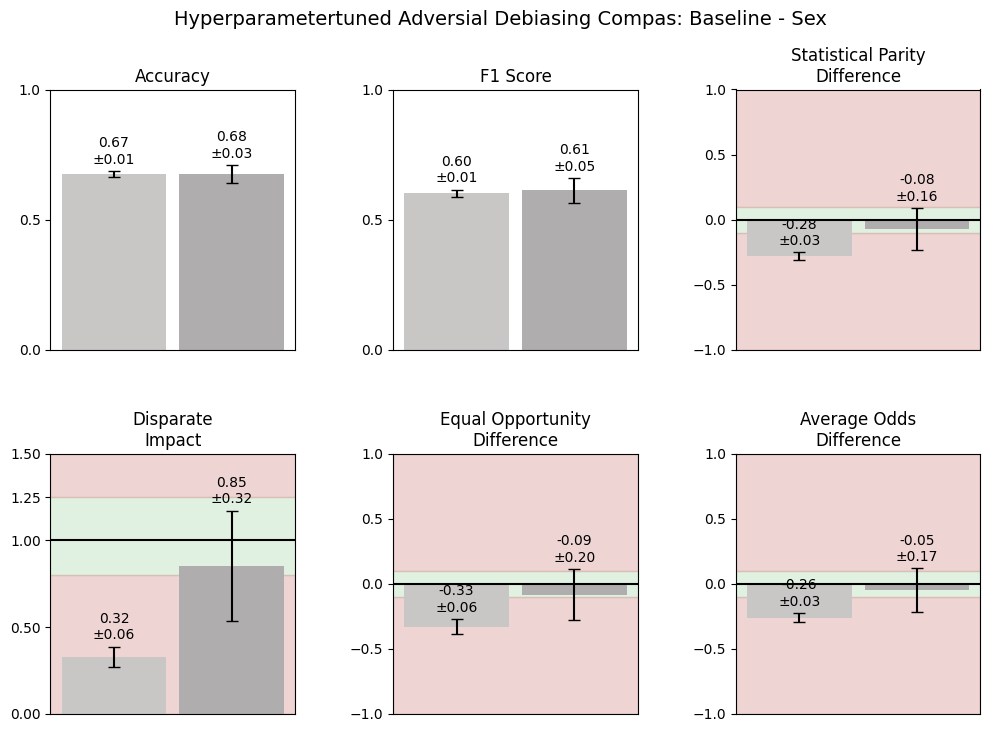

In [12]:
compare_viz_metrics_2x3(baseline_sex_agg, compas_sex_metrics_agg, 'Baseline', 'Race', 'Hyperparametertuned Adversial Debiasing Compas: Baseline - Sex')